# Model Training File



In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


In [2]:
# Paths
DATASET_PATH = "datasets/processed/"
LABELS_CSV = "datasets/processed_labels.csv"
MODEL_SAVE_PATH = "tinyml_dog_model_3.h5"

In [ ]:

# Load dataset labels
df = pd.read_csv(LABELS_CSV)
df["filename"] = df["filename"].apply(lambda x: os.path.join(DATASET_PATH, x))
print(df['label'].value_counts())  

# Perform train-validation split
train_files, val_files, train_labels, val_labels = train_test_split(
    df["filename"], df["label"], test_size=0.2, random_state=42
)

# Check dataset split
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")


label
1    29976
0    14256
Name: count, dtype: int64
Training samples: 35385
Validation samples: 8847


In [19]:


# Load images directly since they are already preprocessed
train_images = np.array([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in train_files])
val_images = np.array([cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in val_files])
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# Expand dimensions to match model input shape (96, 96, 1)
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)

# Ensure pixel values are in float32 and normalized to [0,1]
train_images = train_images.astype(np.float32) / 255.0
val_images = val_images.astype(np.float32) / 255.0


In [15]:
# Check the number of samples in train & validation sets
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")

# Check class balance in both sets
train_df = pd.DataFrame({"filename": train_files, "label": train_labels})
val_df = pd.DataFrame({"filename": val_files, "label": val_labels})

print("\nTraining Set Distribution:")
print(train_df["label"].value_counts())

print("\nValidation Set Distribution:")
print(val_df["label"].value_counts())

Training samples: 35385
Validation samples: 8847

Training Set Distribution:
label
1.0    23947
0.0    11438
Name: count, dtype: int64

Validation Set Distribution:
label
1.0    6029
0.0    2818
Name: count, dtype: int64


In [16]:
print(f"Training data shape: {train_images.shape}")  # Should be (batch_size, 96, 96, 1)
print(f"Validation data shape: {val_images.shape}")  # Shou

Training data shape: (35385, 96, 96, 1)
Validation data shape: (8847, 96, 96, 1)


In [17]:
IMAGE_SIZE = 96
BATCH_SIZE = 32


batch_size = 50
validation_split = 0.1

epochs = 20,10,20
lrates = .001, .0005, .00025

color_mode = 'grayscale'
if color_mode == 'grayscale':
  n_color_chans = 1
elif color_mode == 'rgb':
  n_color_chans = 3
else:
  raise ValueError("color_mode should be either 'rgb' or 'grayscale'")

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

def tinyml_mobilenet():
    input_shape = (96, 96, 1)  # Ensure grayscale input
    num_classes = 1  # Binary classification: Dog vs Not-Dog
    num_filters = 8  # Reduced filters for TinyML

    inputs = Input(shape=input_shape)

    # 1st Layer: Standard Convolution
    x = Conv2D(num_filters, (3,3), strides=2, padding='same', 
               kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)


    # 2nd Layer: Depthwise Separable Convolution
    x = DepthwiseConv2D((3,3), strides=1, padding='same', 
                         depthwise_initializer='he_normal', depthwise_regularizer=l2(1e-4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters *= 2  # Increase filters
    x = Conv2D(num_filters, (1,1), strides=1, padding='same', 
               kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 3rd Layer: Depthwise Separable Convolution
    x = DepthwiseConv2D((3,3), strides=2, padding='same', 
                         depthwise_initializer='he_normal', depthwise_regularizer=l2(1e-4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters *= 2  # Increase filters
    x = Conv2D(num_filters, (1,1), strides=1, padding='same', 
               kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 4th Layer: Depthwise Separable Convolution
    x = DepthwiseConv2D((3,3), strides=1, padding='same', 
                         depthwise_initializer='he_normal', depthwise_regularizer=l2(1e-4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 5th Layer: Depthwise Separable Convolution
    x = DepthwiseConv2D((3,3), strides=2, padding='same', 
                         depthwise_initializer='he_normal', depthwise_regularizer=l2(1e-4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters *= 2  # Increase filters
    x = Conv2D(num_filters, (1,1), strides=1, padding='same', 
               kernel_initializer='he_normal', kernel_regularizer=l2(1e-4), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)  # Prevent overfitting

    # Output Layer
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification (Dog/Not-Dog)

    # Define Model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Compile the Model
model = tinyml_mobilenet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Display Model Summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 8)      │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 48, 48, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_12             │ (None, 48, 48, 8)      │            72 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 48, 48, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 48, 16)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_13             │ (None, 24, 24, 16)     │           144 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 24, 24, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 32)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_14             │ (None, 24, 24, 32)     │           288 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_15             │ (None, 12, 12, 32)     │           288 │
│ (DepthwiseConv2D)               │                        │             

 Total params: 12,833 (50.13 KB)

 Trainable params: 12,417 (48.50 KB)

 Non-trainable params: 416 (1.62 KB)

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight  # Correct import


# Image size and batch size
IMG_SIZE = (96, 96)
BATCH_SIZE = 32
EPOCHS = 30  # Will stop early if needed

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Compute class weights based on dataset size
class_counts = np.array([11438 + 2818, 23947 + 6029])  # Total count for each class
classes = np.array([0, 1])  # Labels: Not-Dog (0), Dog (1)

class_weights = compute_class_weight("balanced", classes=classes, y=np.repeat(classes, class_counts))
class_weights = {i: w for i, w in enumerate(class_weights)}

# Print computed class weights
print(f"Computed Class Weights: {class_weights}")

# Define Model
model = tinyml_mobilenet()  # Call your updated model function

# Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss="binary_crossentropy", 
    metrics=["accuracy"]
)

# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weights,  # Apply class balancing
    callbacks=[early_stopping]
)

# Save model
MODEL_SAVE_PATH = "tinyml_mobilenet_dog_detector.h5"
model.save(MODEL_SAVE_PATH)
print(f"✅ Model training complete! Saved as {MODEL_SAVE_PATH}")


Computed Class Weights: {0: 1.5513468013468013, 1: 0.7377902321857486}
Epoch 1/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6165 - loss: 0.6854 - val_accuracy: 0.6375 - val_loss: 0.6788
Epoch 2/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.6700 - loss: 0.6326 - val_accuracy: 0.5324 - val_loss: 0.7571
Epoch 3/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.6945 - loss: 0.5990 - val_accuracy: 0.7296 - val_loss: 0.5544
Epoch 4/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.7119 - loss: 0.5800 - val_accuracy: 0.7330 - val_loss: 0.5534
Epoch 5/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.7181 - loss: 0.5687 - val_accuracy: 0.7504 - val_loss: 0.5224
Epoch 6/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.7353 - loss: 0.5474 - val_accuracy: 0.6415 - val_loss: 0.6588
Epoch 7/30
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.7448 - loss: 0.5336 - val_accuracy: 0.7571 - val_loss: 0.5116
Epoch

✅ Model training complete! Saved as tinyml_mobilenet_dog_detector.h5


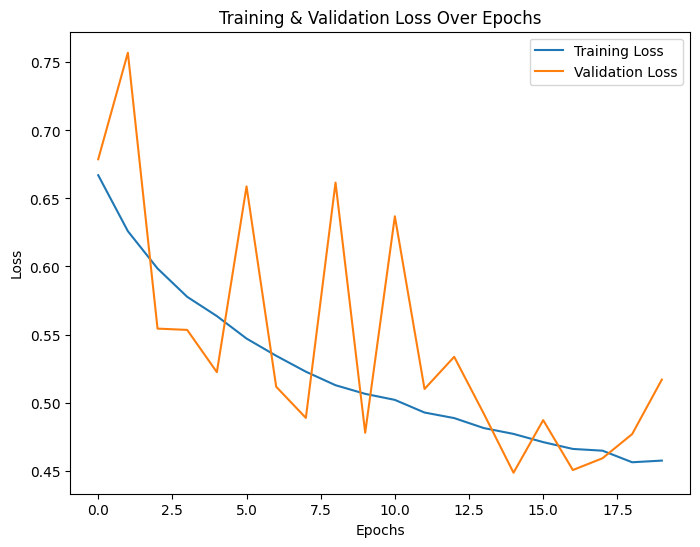

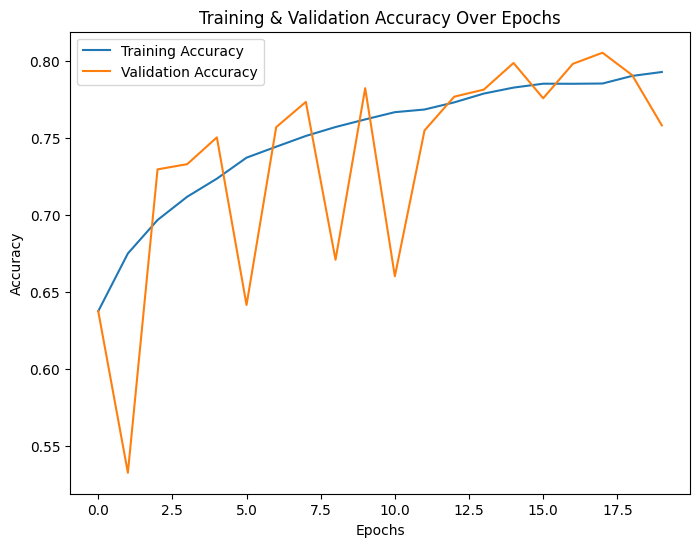

In [22]:



# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Over Epochs')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Abyssinian_71.jpg: Not Dog (Confidence: 0.10119999945163727)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Bengal_194.jpg: Not Dog (Confidence: 0.4973999857902527)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Birman_1.jpg: Dog (Confidence: 0.5299999713897705)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
basset_hound_107.jpg: Dog (Confidence: 0.8562999963760376)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
dog10.jpg: Dog (Confidence: 0.5389999747276306)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
dog3.png: Dog (Confidence: 0.9431999921798706)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
dog4.png: Dog (Confidence: 0.9965999722480774)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
dog7.png: Dog (Confidence: 0.947700023651123)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
food2.png: Dog (Confidence: 0.5347999930381775)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
food4.png: Dog (Confidence: 0.5529999732971191)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
food6.png: Dog (Confidence: 0.8953999876976013)


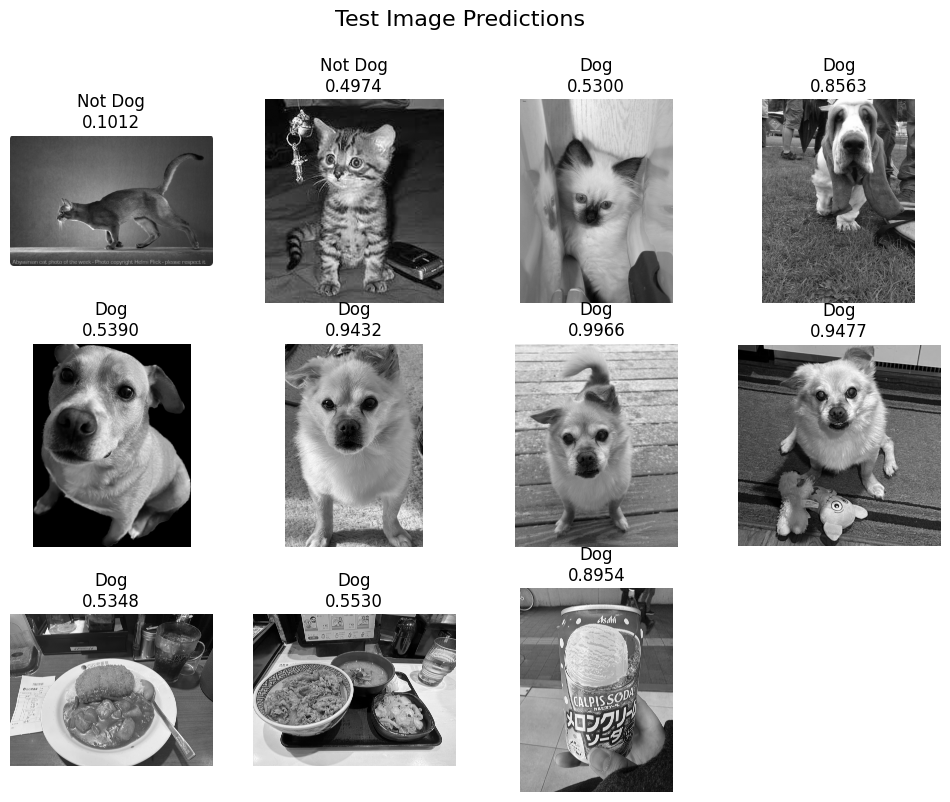

In [23]:


# Paths
MODEL_PATH = "tinyml_dog_model_3.h5"  # Path to trained model
IMAGE_PATH = "datasets/test_img/food2.png"  # Path to test image (replace with your image)
TEST_IMG_FOLDER = "datasets/test_img/"
# Load trained model
#model = tf.keras.models.load_model(MODEL_PATH)
#model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
# Image preprocessing (same as training)
IMG_SIZE = (96, 96)  # Ensure same size used in training


def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    if img is None:
        print(f"⚠️ Warning: Could not read {image_path}. Skipping...")
        return None

    img = cv2.resize(img, IMG_SIZE)  # Resize
    img = img.astype(np.float32) / 255.0  # Normalize

    img = np.expand_dims(img, axis=-1)  # Add grayscale channel dimension (96,96,1)
    img = np.expand_dims(img, axis=0)  # Add batch dimension (1,96,96,1)
    return img

# Function to run predictions on all images in the test folder
def run_predictions():
    test_images = sorted(os.listdir(TEST_IMG_FOLDER))  # Sort files for consistent display
    predictions = []
    images_to_show = []

    for file in test_images:
        if file.endswith((".jpg", ".png")):
            image_path = os.path.join(TEST_IMG_FOLDER, file)
            img = preprocess_image(image_path)
            
            if img is not None:
                prediction = model.predict(img)[0][0]  # Get prediction score
                label = "Dog" if prediction > 0.5 else "Not Dog"
                confidence = round(prediction, 4)

                print(f"{file}: {label} (Confidence: {confidence})")

                # Append image and prediction for visualization
                images_to_show.append(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))  # Read in grayscale
                predictions.append(f"{label}\n{confidence:.4f}")

    # Display images in a matrix
    display_results(images_to_show, predictions)

# Function to display test images and predictions in a grid
def display_results(images, predictions, cols=4):
    rows = (len(images) + cols - 1) // cols  # Calculate number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    fig.suptitle("Test Image Predictions", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap="gray")  # Display image in grayscale
            ax.set_title(predictions[i])  # Show prediction
            ax.axis("off")
        else:
            ax.axis("off")  # Hide extra subplots

    plt.show()

# Run the predictions
run_predictions()

In [24]:

# Convert model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted TFLite model
TFLITE_MODEL_PATH = "tinyml_mobilenet_dog_detector.tflite"
with open(TFLITE_MODEL_PATH, "wb") as f:
    f.write(tflite_model)

print(f"✅ Model successfully converted to TensorFlow Lite! Saved as {TFLITE_MODEL_PATH}")


INFO:tensorflow:Assets written to: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpvzbykifd/assets


INFO:tensorflow:Assets written to: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpvzbykifd/assets


Saved artifact at '/var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpvzbykifd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='keras_tensor_116')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  13437957712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437764048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437764624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437959248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437959824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437765584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437765200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437766544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437765776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437764816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437767

W0000 00:00:1743361253.513290 3082784 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.


✅ Model successfully converted to TensorFlow Lite! Saved as tinyml_mobilenet_dog_detector.tflite


W0000 00:00:1743361253.513440 3082784 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-30 15:00:53.514214: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpvzbykifd
2025-03-30 15:00:53.515169: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-30 15:00:53.515174: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpvzbykifd
I0000 00:00:1743361253.525640 3082784 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-03-30 15:00:53.527901: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-30 15:00:53.595559: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpvzbykifd
2025-03-30 15:00:53.614201: I tensorflow/cc/s

In [25]:
# Create a representative dataset function for quantization
def representative_dataset():
    for _ in range(100):
        # Generate random grayscale images (96x96x1) with values in range [0,1]
        sample = np.random.rand(1, 96, 96, 1).astype(np.float32)
        yield [sample]

# Convert the model to a fully quantized TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enable optimization
converter.representative_dataset = representative_dataset  # Use representative data
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]  # Full integer
converter.inference_input_type = tf.uint8  # Ensure input type is uint8
converter.inference_output_type = tf.uint8  # Ensure output type is uint8

tflite_model = converter.convert()

# Save the quantized TFLite model
QUANTIZED_TFLITE_MODEL_PATH = "tinyml_mobilenet_dog_detector_quantized.tflite"
with open(QUANTIZED_TFLITE_MODEL_PATH, "wb") as f:
    f.write(tflite_model)

print(f"✅ Quantized TFLite model saved as {QUANTIZED_TFLITE_MODEL_PATH}")

INFO:tensorflow:Assets written to: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmp_49srv_a/assets


INFO:tensorflow:Assets written to: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmp_49srv_a/assets


Saved artifact at '/var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmp_49srv_a'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='keras_tensor_116')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  13437957712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437764048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437764624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437959248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437959824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437765584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437765200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437766544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437765776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437764816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13437767

/Users/pkth002/Documents/Machine-Learning-for-IoT-main/_env/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ Quantized TFLite model saved as tinyml_mobilenet_dog_detector_quantized.tflite


W0000 00:00:1743361293.642270 3082784 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1743361293.642280 3082784 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-30 15:01:33.642394: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmp_49srv_a
2025-03-30 15:01:33.643353: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-30 15:01:33.643360: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmp_49srv_a
2025-03-30 15:01:33.655022: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-30 15:01:33.717469: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmp_49srv_a
2025-03-30 15:01:33.735660: I tensorflow/cc/saved_model/loader.cc:

In [26]:
import tensorflow as tf

# Load the TFLite model
TFLITE_MODEL_PATH = "tinyml_mobilenet_dog_detector_quantized.tflite"
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)

# Print model details
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("✅ Model Loaded Successfully!")
print("📌 Input Details:", input_details)
print("📌 Output Details:", output_details)


✅ Model Loaded Successfully!
📌 Input Details: [{'name': 'serving_default_keras_tensor_116:0', 'index': 0, 'shape': array([ 1, 96, 96,  1], dtype=int32), 'shape_signature': array([-1, 96, 96,  1], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.003921566065400839, 0), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
📌 Output Details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 35, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00390625, 0), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


/Users/pkth002/Documents/Machine-Learning-for-IoT-main/_env/lib/python3.11/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [28]:
import tensorflow as tf
import numpy as np

# Load the trained Keras model
MODEL_SAVE_PATH = "tinyml_mobilenet_dog_detector.h5"
model = tf.keras.models.load_model(MODEL_SAVE_PATH)

# Create a representative dataset function for quantization
def representative_dataset():
    for _ in range(100):
        sample = np.random.rand(1, 96, 96, 1).astype(np.float32)  # Fake grayscale images
        yield [sample]

# Convert the model to a fully quantized TensorFlow Lite model (int8)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]  # Force INT8
converter.inference_input_type = tf.int8  # Force int8 input
converter.inference_output_type = tf.int8  # Force int8 output

tflite_model = converter.convert()

# Save the quantized TFLite model
INT8_TFLITE_MODEL_PATH = "tinyml_mobilenet_dog_detector_int8.tflite"
with open(INT8_TFLITE_MODEL_PATH, "wb") as f:
    f.write(tflite_model)

print(f"✅ INT8 Quantized Model Saved as {INT8_TFLITE_MODEL_PATH}")


INFO:tensorflow:Assets written to: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpytrq2_3i/assets


INFO:tensorflow:Assets written to: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpytrq2_3i/assets


Saved artifact at '/var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpytrq2_3i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  15291939344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15291940304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15292826448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15291940112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15291940496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15292827408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15292827024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15292828368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15292827600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15292826640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15292829328

/Users/pkth002/Documents/Machine-Learning-for-IoT-main/_env/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ INT8 Quantized Model Saved as tinyml_mobilenet_dog_detector_int8.tflite


W0000 00:00:1743363920.776942 3082784 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1743363920.776951 3082784 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-30 15:45:20.777066: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpytrq2_3i
2025-03-30 15:45:20.777884: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-30 15:45:20.777888: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpytrq2_3i
2025-03-30 15:45:20.788761: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-30 15:45:20.851264: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/bh/5s5mvd4s687fd8p3w7f335k80000gp/T/tmpytrq2_3i
2025-03-30 15:45:20.869069: I tensorflow/cc/saved_model/loader.cc:

In [29]:
import tensorflow as tf

# Load the new INT8 model
interpreter = tf.lite.Interpreter(model_path="tinyml_mobilenet_dog_detector_int8.tflite")
interpreter.allocate_tensors()

# Get input details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("✅ INT8 Model Loaded Successfully!")
print("📌 Input Type:", input_details[0]['dtype'])  # Should print int8
print("📌 Output Type:", output_details[0]['dtype'])  # Should print int8


✅ INT8 Model Loaded Successfully!
📌 Input Type: <class 'numpy.int8'>
📌 Output Type: <class 'numpy.int8'>


/Users/pkth002/Documents/Machine-Learning-for-IoT-main/_env/lib/python3.11/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
